# Классификация заемщиков линейными моделями

## курс "Машинное обучение 1", программа AIMasters, 2024

## Студент: Пономаренко Алексей Сергеевич

## Реализация алгоритмов (5 баллов)

Ниже нужно написать собственную реализацию линейного классификатора с произвольной функцией потерь и реализацию функции и градиента функции потерь для логистической регрессии. Реализации можно частично проверить через юнит тесты. В этом блоке можно использовать только `numpy, scipy`.


В `BinaryLogisticLoss` вам нужно реализовать расчет лосса и его градиента для функции
$$L(w) = \frac{1}{N} \sum_{N} [\log(1 + \exp(-y_i\langle w, x_i\rangle))] + \lambda \lVert w \rVert^2_2, \quad y \in \{-1, 1\}$$

- `func(self, X, y, w)` — вычисление значения функции потерь на матрице признаков X, векторе ответов y с вектором весов w.
- `grad(self, X, y, w)` — вычисление значения градиента функции потерь на матрице признаков X, векторе ответов y с вектором весов w.

У обоих методов одинаковые аргументы:
- X - выборка объектов
- y - вектор ответов
- w - вектор коэффициентов модели

Вектор коэффициентов имеет вид: w = `[bias, weights]`, то есть нулевой элемент w - `bias`, остальное - веса, участвующие в скалярном произведении. **Важно:** `bias` не участвует в расчете слагаемого с $\lambda$.

Обратите внимание, что на матрица X на входе без столбца с 1 в начале. Пример изменения Х внутри кода функций:
```python
X_new = np.c_[np.ones(X.shape[0]), X]
```

In [1]:
import numpy as np
import scipy
from scipy.special import expit
from scipy.special import logsumexp

class BinaryLogisticLoss():
    """
    Loss function for binary logistic regression.
    It should support l2 regularization.
    """

    def __init__(self, l2_coef):
        """
        Parameters
        ----------
        l2_coef - l2 regularization coefficient
        """
        self.l2_coef = l2_coef

    def func(self, X, y, w):
        """
        Get loss function value for data X, target y and coefficient w; w = [bias, weights].

        Parameters
        ----------
        X : numpy.ndarray
        y : 1d numpy.ndarray
        w : 1d numpy.ndarray

        Returns
        -------
        : float
        """
        X_new = np.c_[np.ones(X.shape[0]), X]

        a = X_new @ w

        logistic_loss = np.mean(
            logsumexp([np.zeros_like(a), (-y * a)], axis=0),
            axis=0
            )

        l2_regularization = self.l2_coef * np.sum(w[1:] @ w[1:])

        return logistic_loss + l2_regularization

    def grad(self, X, y, w):
        """
        Get loss function gradient for data X, target y and coefficient w; w = [bias, weights].

        Parameters
        ----------
        X : numpy.ndarray
        y : 1d numpy.ndarray
        w : 1d numpy.ndarray

        Returns
        -------
        : 1d numpy.ndarray
        """
        X_new = np.c_[np.ones(X.shape[0]), X]

        a = X_new @ w

        grad_logistic_loss = np.mean(X_new * y[:,np.newaxis] * (expit(y * a) - 1)[:,np.newaxis], axis=0) # np.mean(X_new.T * y * (expit(y * a) - 1), axis=1)

        grad_weights_for_reg = np.zeros_like(w)
        grad_weights_for_reg[1:] = w[1:]
        grad_l2_regularization = 2 * self.l2_coef * grad_weights_for_reg

        return grad_logistic_loss + grad_l2_regularization

In [2]:
loss_function = BinaryLogisticLoss(l2_coef=1.0)
X = np.array([
    [1, 2],
    [3, 4],
    [-5, 6]
])
y = np.array([-1, 1, 1])
w = np.array([1, 2, 3])
assert np.isclose(loss_function.func(X, y, w), 16.00008, atol=1e-5)

loss_function = BinaryLogisticLoss(l2_coef=0.0)
X = np.array([
    [10 ** 5],
    [-10 ** 5],
    [10 ** 5]
])
y = np.array([1, -1, 1])
w = np.array([1, 100])
assert np.isclose(loss_function.func(X, y, w), 0, atol=1e-5)

loss_function = BinaryLogisticLoss(l2_coef=0.0)
X = np.array([
    [10 ** 2],
    [-10 ** 2],
    [10 ** 2]
])
y = np.array([-1, 1, -1])
w = np.array([1, 100])
assert np.isclose(loss_function.func(X, y, w), 10000.333334, atol=1e-5)

loss_function = BinaryLogisticLoss(l2_coef=1.0)
X = np.array([
    [1, 2],
    [3, 4],
    [-5, 6]
])
y = np.array([-1, 1, 1])
w = np.array([1, 2, 3])
right_gradient = np.array([0.33325, 4.3335 , 6.66634])
assert np.isclose(loss_function.grad(X, y, w), right_gradient, atol=1e-5).all()

В `LinearModel` нужно реализовать линейную модель, поддерживающей обучение через стохастический градиентные спуск.

`__init__` — инициализатор класса с параметрами:
- loss_function — функция потерь, заданная классом
- batch_size — размер подвыборки, по которой считается градиент
- step_alpha — параметр шага градиентного спуска
- tolerance — критерий останова метода — модуль разности значений функции потерь на соседних итерациях метода меньше tolerance, не весов.
- max_iter — максимальное число итераций (эпох)

`fit(self, X, y, w_0=None)` — обучение линейной модели

- X — выборка объектов
- y — вектор ответов
- w_0 — начальное приближение вектора коэффициентов, если None, то необходимо инициализировать внутри метода. w_0 имеет вид `[bias_0, weights_0]`.

`predict_proba(self, X)` — получение вероятностей для 2х классов
- X — выборка объектов

Вы можете поменять формат изменения шага градиентного спуска, по дефолту предполагается, что можно использовать просто `step_alpha`.

Про sgd: нет необходимости проводить честное семплирование для каждого батча в методе стохасического градиентного спуска. Вместо этого предлагается в начале одной эпохи сгенерировать случайную перестановку индексов объектов, а затем последовательно выбирать объекты для нового батча из элементов этой перестановки. Псевдокод:
```python
epoch_rand_indexes = np.random.permutation(X.shape[0])
inner_cycle_length = int(np.ceil(X.shape[0] / self.batch_size))

for i in range(inner_cycle_length):
    start_index = self.batch_size * i
    finish_index = self.batch_size * (i + 1)
    batch_indexes = epoch_rand_indexes[start_index:finish_index]
    # тут считаем градиент только по batch_indexes
```

Еще несколько советов:

В промежуточных вычислениях стоит избегать вычисления $exp(−y_i⟨x_i,w⟩)$, иначе может произойти переполнение.
Вместо этого следует напрямую вычислять необходимые величины с помощью специализированных для этого функций: `np.logaddexp, scipy.special.logsumexp и scipy.special.expit`. В ситуации, когда вычисления экспоненты обойти не удаётся, можно воспользоваться процедурой «клипинга» (функция `numpy.clip`).


In [3]:
import numpy as np
from scipy.special import expit

class LinearModel:
    def __init__(
        self,
        loss_function,
        batch_size=100,
        step_alpha=1,
        step_beta=0,
        tolerance=1e-5,
        max_iter=1000,
        random_seed=0,
        **kwargs
    ):
        """
        Parameters
        ----------
        loss_function : BaseLoss inherited instance
            Loss function to use
        batch_size : int
        step_alpha : float
        tolerance : float
            Tolerace for stop criterio.
        max_iter : int
            Max amount of epoches in method.
        """
        self.loss_function = loss_function
        self.batch_size = batch_size
        self.step_alpha = step_alpha
        self.step_beta = step_beta
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_seed = random_seed

        np.random.seed(random_seed)

    def fit(self, X, y, w_0=None):
        """
        Parameters
        ----------
        X : numpy.ndarray or scipy.sparse.csr_matrix
            2d matrix, training set.
        y : numpy.ndarray
            1d vector, target values.
        w_0 : numpy.ndarray
            1d vector in binary classification.
            Initial approximation for SGD method - [bias, weights]
        """
        def learning_rate(t, alpha, beta):
            """
            function for calculating learning_rate on each iteration
            k: int
            alpha, beta: float
            """
            return alpha / (t ** beta)

        if w_0 is None:
            w = np.random.normal(size = X.shape[1]) * 0.01
            w = np.hstack( (0, w) )
        else:
            w = w_0.copy()

        loss_before_epoch = self.loss_function.func(X, y, w)

        for i in range (1, self.max_iter + 1):
            lr = learning_rate(i, self.step_alpha, self.step_beta)

            if self.batch_size >= X.shape[0]:
                w -= lr * self.loss_function.grad(X, y, w)

            else:
                epoch_rand_indexes = np.random.permutation(X.shape[0])
                inner_cycle_length = int(np.ceil(X.shape[0] / self.batch_size))

                for i in range(inner_cycle_length):
                    start_index = self.batch_size * i
                    finish_index = min(self.batch_size * (i + 1), X.shape[0])
                    batch_indexes = epoch_rand_indexes[start_index:finish_index]
                    X_batch = X[batch_indexes]
                    y_batch = y[batch_indexes]
                    w -= lr * self.loss_function.grad(X_batch, y_batch, w)

            loss_after_epoch = self.loss_function.func(X, y, w)
            if abs(loss_after_epoch - loss_before_epoch) < self.tolerance:
                break

        self.w = w

    def predict_proba(self, X):
        """
        Parameters
        ----------
        X : numpy.ndarray or scipy.sparse.csr_matrix
            2d matrix, test set.
        Returns
        -------
        : numpy.ndarray
            probs, shape=(X.shape[0], 2)
        """
        X_new = np.c_[np.ones(X.shape[0]), X]

        a = X_new @ self.w

        probs = np.zeros((X.shape[0], 2), dtype=float)
        proba = expit(a)
        probs[:,0] = 1-proba
        probs[:,1] = proba

        return probs

In [4]:
# обратите внимание, что тут достаточно простой тест
# ниже еще есть проверка для данных из data
X1 = np.random.randint(1, 4, (1000, 10))
X2 = np.random.randint(-4, 0, (1000, 10))
X = np.vstack((X1, X2))
y = np.array([-1] * 1000 + [1] * 1000)
loss_function = BinaryLogisticLoss(l2_coef=0.1)
linear_model = LinearModel(
    loss_function=loss_function,
    batch_size=100,
    step_alpha=1,
    step_beta=0,
    tolerance=1e-4,
    max_iter=1000,
)
linear_model.fit(X, y)
prediction_probs = linear_model.predict_proba(X)
predictions = (prediction_probs > 0.5).astype('int')[:, 1] * 2 - 1
assert np.isclose(predictions, y).all()

## Эксперименты (5 баллов)

Эксперименты будем проводить на [датасете](https://www.kaggle.com/competitions/home-credit-default-risk/overview) по классификации заемщиков на плохих (target = 1: клиент с "payment difficulties") и хороших (target = 0: все остальные). Для экспериментов будем использовать лишь основной файл `application_train.csv`, а также перекодируем таргет в метки -1, 1.

Описание колонок находится в файле `description.csv`.

Для начала мы за вас считаем данные и поделим на обучение и тест.

Код в чтение, разбиение и предобработке менять не нужно.

Выполняя задания, не забывайте про [устав](https://t.me/c/2206639786/270/271).

In [5]:
# не меняем код
import pandas as pd
pd.options.display.max_columns = 100
pd.options.display.max_rows = 150


data = pd.read_csv('application_train.csv')
data.columns = [
    '_'.join([word.lower() for word in col_name.split(' ') if word != '-']) for col_name in data.columns
]
data.target = data.target.map({0: -1, 1: 1})
data.head(3)

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,...,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,fondkapremont_mode,housetype_mode,totalarea_mode,wallsmaterial_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,-1,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,-1,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# не меняем код
test_idx = data.sk_id_curr % 10 >= 7
data_dict = dict()
data_dict['tst'] = data.loc[test_idx].reset_index(drop=True)
data_dict['tr'] = data.loc[~test_idx].reset_index(drop=True)

for key, df in data_dict.items():
    print(key, 'shape:', df.shape)

tst shape: (92221, 122)
tr shape: (215290, 122)


In [7]:
# не меняем код
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

features = data.select_dtypes(np.number).drop(columns=['target', 'sk_id_curr']).columns

X_tr, X_tst = data_dict["tr"][features].to_numpy(), data_dict["tst"][features].to_numpy()
y_tr, y_tst = data_dict["tr"]["target"].to_numpy(), data_dict["tst"]["target"].to_numpy()


prep = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

prep.fit(X_tr)

X_tr = prep.transform(X_tr)
X_tst = prep.transform(X_tst)

Инициализируйте написанный выше лосс и классификатор, для `BinaryLogisticLoss` возьмите параметр `l2_coef=0.1`, параметры `LinearModel` нужно подобрать так, чтобы [roc_auc_score](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.roc_auc_score.html) был больше 0.72.

In [8]:
loss_function = BinaryLogisticLoss(l2_coef=0.1)
clf = LinearModel(loss_function=loss_function,
                  batch_size=3000,
                  step_alpha=2e-3,
                  step_beta=0,
                  tolerance=2e-4,
                  max_iter=30,
                  random_seed=911
                  )

In [9]:
clf.fit(X_tr, y_tr)

In [10]:
from sklearn.metrics import roc_auc_score

assert roc_auc_score(y_tst, clf.predict_proba(X_tst)[:, 1]) > 0.72

Ура! Ваша модель что-то может :)

Теперь нужно поисследовать реализацию [LogisticRegression](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html) в sklearn.

Сравните различные `solver` по времени обучения/качеству на тесте. Напишите выводы.

Выбейте на тесте больше `0.737` roc_auc_score.
Для поиска лучшей модели можно использовать:
- optuna
- [GridSearchCV](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html)
- свои наблюдения и интуицию


Для начала посмотрим разные солверы, доступные в sklearn. Пройдемся по каждому с остальными зафиксированными гиперпараметрами по умолчанию.

In [11]:
from sklearn.linear_model import LogisticRegression
import time

In [12]:
solvers = ['lbfgs', 'liblinear', 'saga', 'newton-cg']
results = {}

for solver in solvers:
    start_time = time.time()
    clf = LogisticRegression(solver=solver, max_iter=200)
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict_proba(X_tst)[:, 1]
    score = roc_auc_score(y_tst, y_pred)
    elapsed_time = time.time() - start_time
    results[solver] = {'roc_auc': score, 'time': elapsed_time}

print(results)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'lbfgs': {'roc_auc': 0.7352953508051248, 'time': 2.0450851917266846}, 'liblinear': {'roc_auc': 0.7372069233523872, 'time': 91.85627579689026}, 'saga': {'roc_auc': 0.7339646049927515, 'time': 107.85349440574646}, 'newton-cg': {'roc_auc': 0.7372042444836339, 'time': 11.56511902809143}}


### Анализируем полученные данные:
- все солверы с параметрами по умолчанию дали точность, близкую к пороговой (0.737)
- солвер saga работал дольше всех, так еще и вообще не сошелся с такими гиперпараметрами за 200 итераций - его точно не берем
- солвер lbfgs показал метрику roc_auc чуть ниже порога - тоже оставим его на потом (хотя время его обучения очень привлекает)
- остались два солвера, которые преодолели отметку в 0.737 roc_auc на гиперпарметрах по умолчанию - liblinear и newton-cg.

### Запускаем оптимизацию Optuna с BOHB TPESampler'ом.
Теперь попробуем найти оптимальные параметры с помощью Optuna. Для перебора солверов возьмем только 2: `lbfgs` как самый быстрый и `newton-cg` как оптимальный по качеству и времени работы.

In [13]:
!pip install -q --upgrade optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.4 MB/s eta 0:00:00


In [14]:
import optuna

In [15]:
def objective(trial, X_tr, y_tr, X_val, y_val):
    params = {
        'C' : trial.suggest_float('C', 1e-4, 1e1, log=True),
        'solver' : trial.suggest_categorical('solver', ['lbfgs', 'newton-cg']),
        'max_iter' : trial.suggest_int('max_iter', 100, 400, step=75)
    }

    model = LogisticRegression(**params)
    model.fit(X_tr, y_tr)

    y_pred = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)

    return score

In [16]:
import os
os.cpu_count()

2

In [17]:
n_trials = 100

bohb_sampler = optuna.samplers.TPESampler(
    n_startup_trials = 0.4*n_trials,
    n_ei_candidates=15,

    multivariate=True
)
study = optuna.create_study(sampler=bohb_sampler, direction='maximize')


from functools import partial

# Нужно сделать так, чтобы наша функция-objective в итоге принимала только аргумент trial.
# Поэтому зафиксируем заранее все остальные
obj_func = partial(objective, X_tr=X_tr, X_val=X_tst, y_tr=y_tr, y_val=y_tst)

study.optimize(obj_func, n_trials=n_trials, n_jobs=2)

/usr/local/lib/python3.10/dist-packages/optuna/_experimental.py:30: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2024-11-08 18:42:10,157] A new study created in memory with name: no-name-d7dcea32-eb95-4bc8-aae5-58a5c583609b
[I 2024-11-08 18:42:12,784] Trial 1 finished with value: 0.7311336105917767 and parameters: {'C': 0.0002247044097907728, 'solver': 'lbfgs', 'max_iter': 175}. Best is trial 1 with value: 0.7311336105917767.
[I 2024-11-08 18:42:15,868] Trial 2 finished with value: 0.730988856963642 and parameters: {'C': 0.000209386588656135, 'solver': 'lbfgs', 'max_iter': 100}. Best is trial 1 with value: 0.7311336105917767.
[I 2024-11-08 18:42:15,928] Trial 0 finished with value: 0.7353137776966732 and parameters: {'C': 0.1892650519447366, 'solver': 'lbfgs', 'max_iter': 325}. Best is trial 0 with value: 0.7353137776966732.
[I 2024-11-08 18:42:27,423] Trial 3 finished with value: 0.73464400999342

In [18]:
from optuna.visualization import plot_slice

plot_slice(study, target_name='roc_auc')

In [19]:
study.trials_dataframe().sort_values(by='value', ascending=False).head(10)

,number,value,datetime_start,datetime_complete,duration,params_C,params_max_iter,params_solver,state
75,75,0.737970,2024-11-08 18:57:03.396766,2024-11-08 18:57:51.391287,0 days 00:00:47.994521,9.917448,250,newton-cg,COMPLETE
95,95,0.737965,2024-11-08 19:03:06.218572,2024-11-08 19:03:53.957326,0 days 00:00:47.738754,9.868371,325,newton-cg,COMPLETE
69,69,0.737965,2024-11-08 18:54:56.760975,2024-11-08 18:55:48.053365,0 days 00:00:51.292390,9.466685,325,newton-cg,COMPLETE
58,58,0.737964,2024-11-08 18:51:41.677186,2024-11-08 18:52:29.517304,0 days 00:00:47.840118,9.478754,250,newton-cg,COMPLETE
88,88,0.737963,2024-11-08 19:00:59.826098,2024-11-08 19:01:48.429579,0 days 00:00:48.603481,9.350959,325,newton-cg,COMPLETE
93,93,0.737962,2024-11-08 19:02:18.985530,2024-11-08 19:03:06.204331,0 days 00:00:47.218801,9.381042,250,newton-cg,COMPLETE
76,76,0.737958,2024-11-08 18:57:41.823907,2024-11-08 18:58:28.668902,0 days 00:00:46.844995,8.922497,250,newton-cg,COMPLETE
47,47,0.737958,2024-11-08 18:47:52.401748,2024-11-08 18:48:39.152233,0 days 00:00:46.750485,9.158891,250,newton-cg,COMPLETE
71,71,0.737954,2024-11-08 18:55:48.057511,2024-11-08 18:56:35.244188,0 days 00:00:47.186677,8.523928,250,newton-cg,COMPLETE
63,63,0.737952,2024-11-08 18:53:35.932631,2024-11-08 18:54:23.085706,0 days 00:00:47.153075,8.467431,250,newton-cg,COMPLETE


In [20]:
study.best_trial.params

{'C': 9.917448333429535, 'solver': 'newton-cg', 'max_iter': 250}

In [21]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=9.8, solver='newton-cg', max_iter=100)

In [22]:
clf.fit(X_tr, y_tr)

LogisticRegression(C=9.8, solver='newton-cg')

In [23]:
assert roc_auc_score(y_tst, clf.predict_proba(X_tst)[:, 1]) > 0.737

Нарисуйте график `feature - weight`, показывающий `top_k` (на ваш выбор) признаков по модулю веса и их значения весов. <br>
Признаки должны идти по убыванию модуля веса. <br>
Лучше использовать [barplot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html) или аналоги из других библиотек. <br>
Опишите наблюдения, используя описания признаков в `description.csv`.

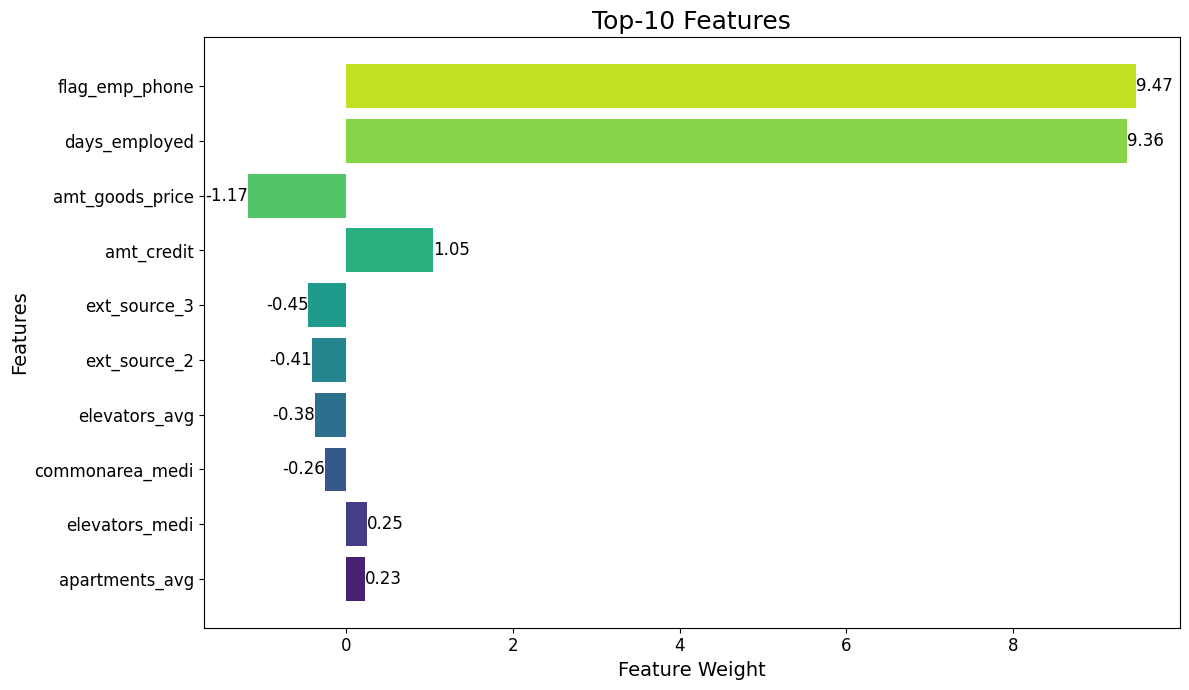

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

weights = clf.coef_.flatten()

sorted_indices = np.argsort(np.abs(weights))

sorted_weights = weights[sorted_indices[-10:]]
sorted_feature_names = features[sorted_indices[-10:]]

fig, ax = plt.subplots(figsize=(12, 7))

bars = ax.barh(sorted_feature_names, sorted_weights, color=sns.color_palette('viridis', len(sorted_weights)))

ax.set_xlabel('Feature Weight', fontsize=14)
ax.set_ylabel('Features', fontsize=14)
ax.set_title('Top-10 Features', fontsize=18)
ax.tick_params(axis='both', labelsize=12)

ax.bar_label(bars, fmt='%.2f', fontsize=12)

plt.tight_layout()
plt.show()

### Выводы из построенного графика.
Из графика видно, что из всех признаков выделяются 2 с наибольшим по модулю весом:
- `flag_emp_phone` : оставил ли клиент свой рабочий номер телефона
- `days_employed` : за сколько дней до подачи заявления клиент устроился на работу

Посмотрим на эти признаки без модуля.

In [25]:
weights = clf.coef_.flatten()

top_features = ['flag_emp_phone', 'days_employed']

indices = [np.where(features == feature)[0][0] for feature in top_features]

top_weights = weights[indices]

for feature, weight in zip(top_features, top_weights):
    print(f"Weight for {feature}: {weight:.4f}")

Weight for flag_emp_phone: 9.4663
Weight for days_employed: 9.3632


Как мы видим, оба эти признака имеют положительный вес => они положительно и очень сильно (неожиданно) влияют на результат предсказания.

Выведите топ признаков с наибольшим/наименьшим абсолютным весом.<br>
Опишите наблюдения (ответьте на вопрос: правда ли, что если признак `X` больше/меньше, то вероятность дефолта клиента выше/ниже?).

Построим такой же график, только для топ-10 самых маленьких по модулю фичей.

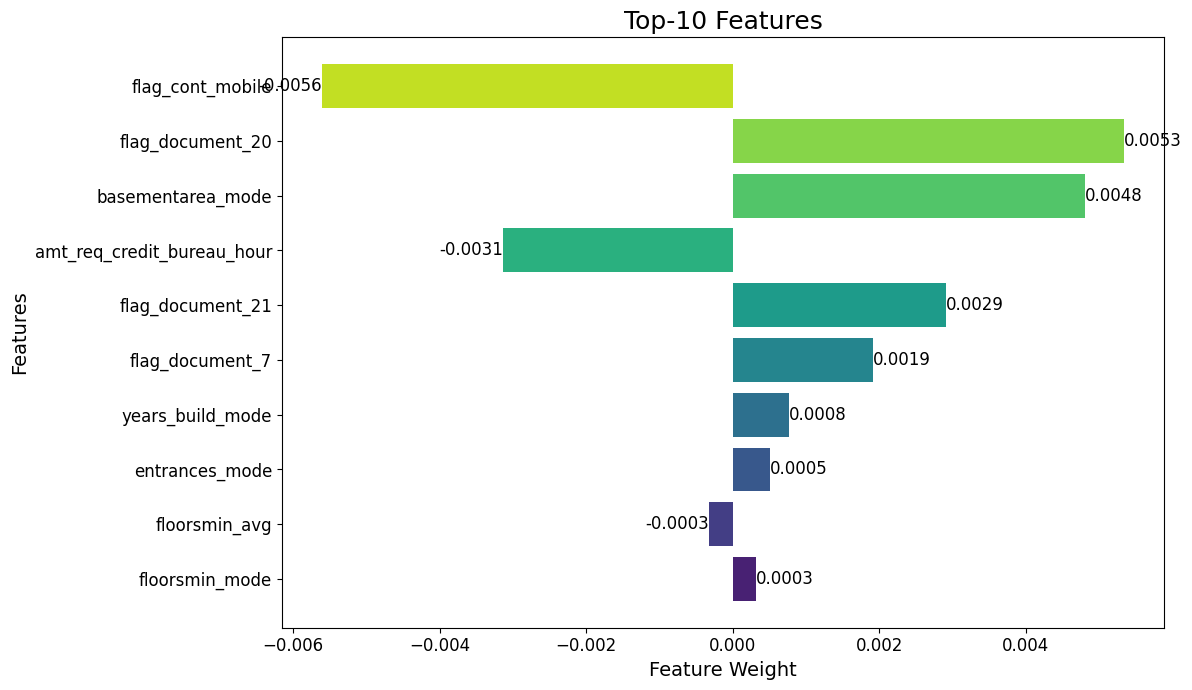

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

weights = clf.coef_.flatten()

sorted_indices = np.argsort(np.abs(weights))

sorted_weights = weights[sorted_indices[:10]]
sorted_feature_names = features[sorted_indices[:10]]

fig, ax = plt.subplots(figsize=(12, 7))

bars = ax.barh(sorted_feature_names, sorted_weights, color=sns.color_palette('viridis', len(sorted_weights)))

ax.set_xlabel('Feature Weight', fontsize=14)
ax.set_ylabel('Features', fontsize=14)
ax.set_title('Top-10 Features', fontsize=18)
ax.tick_params(axis='both', labelsize=12)

ax.bar_label(bars, fmt='%.4f', fontsize=12)

plt.tight_layout()
plt.show()

### Правда ли, что если признак X больше/меньше, то вероятность дефолта клиента выше/ниже?
Так как данные перед обучением были стандартизованы (то есть все фичи имеют примерно одинаковый диапазон значений), это означает, что мы можем интерпретировать модули весов как "степень значимости" данной фичи.

Это означает, что если вес по модулю очень маленький, то даже при сильном численном изменении данного признака, результат алгоритма не сильно поменяется, и так же и в другую сторону: если вес по модулю большой, то даже несильное его изменение может привести к совершенно другому результату.

**Итог:** если вес имеет положителный знак, то чем больше признак, тем выше вероятность дефолта, если имеет отрицательный знак - то чем больше, тем меньше.

### Мой личный вопрос.
Расскажите, пожалуйста, почему может быть такая контринтуитивная ситуация: фича `days_employed` очень сильно влияет на предсказание и имеет положительный знак. То есть, чем больше дней человек проработал на данной позиции, тем выше вероятность, что он дефолтный. Это чисто из-за данных или именно с моей интерпретацией и пониманием что-то не так?

**Пожалуйста, напишите ответ на данный вопрос в тг @alexxponomarenko**